In [1]:
import numpy as np
from skimage.io import imread
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from fish.image.zds import ZDS
from fish.image.vol import redim, filter_flat, unfilter_flat
import flika as flk
flk.start_flika()
from flika.window import Window as flw
%matplotlib inline

Starting flika
Starting flika inside IPython


In [2]:
fname = '/groups/ahrens/ahrenslab/davis/tmp/20181209_8_1_th1gc6s_gfaprgeco_hucgc_6dpf_CLOL_singleplane_20181209_211424/20181209_8_1_th1gc6s_gfaprgeco_hucgc_6dpf_CLOL_singleplane_20181209_211424_dff_ds4.tif'
data = imread(fname)

In [6]:
flk.start_flika()

Starting flika
flika menubar already initialized.
Starting flika inside IPython


/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/pyqtgraph/graphicsItems/PlotDataItem.py:533: RuntimeWarning: invalid value encountered in log10
  y = np.log10(y)


In [5]:
flw(data)

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/pyqtgraph/imageview/ImageView.py:588: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = data[sl]


In [3]:
data_flat = redim(data, 2)

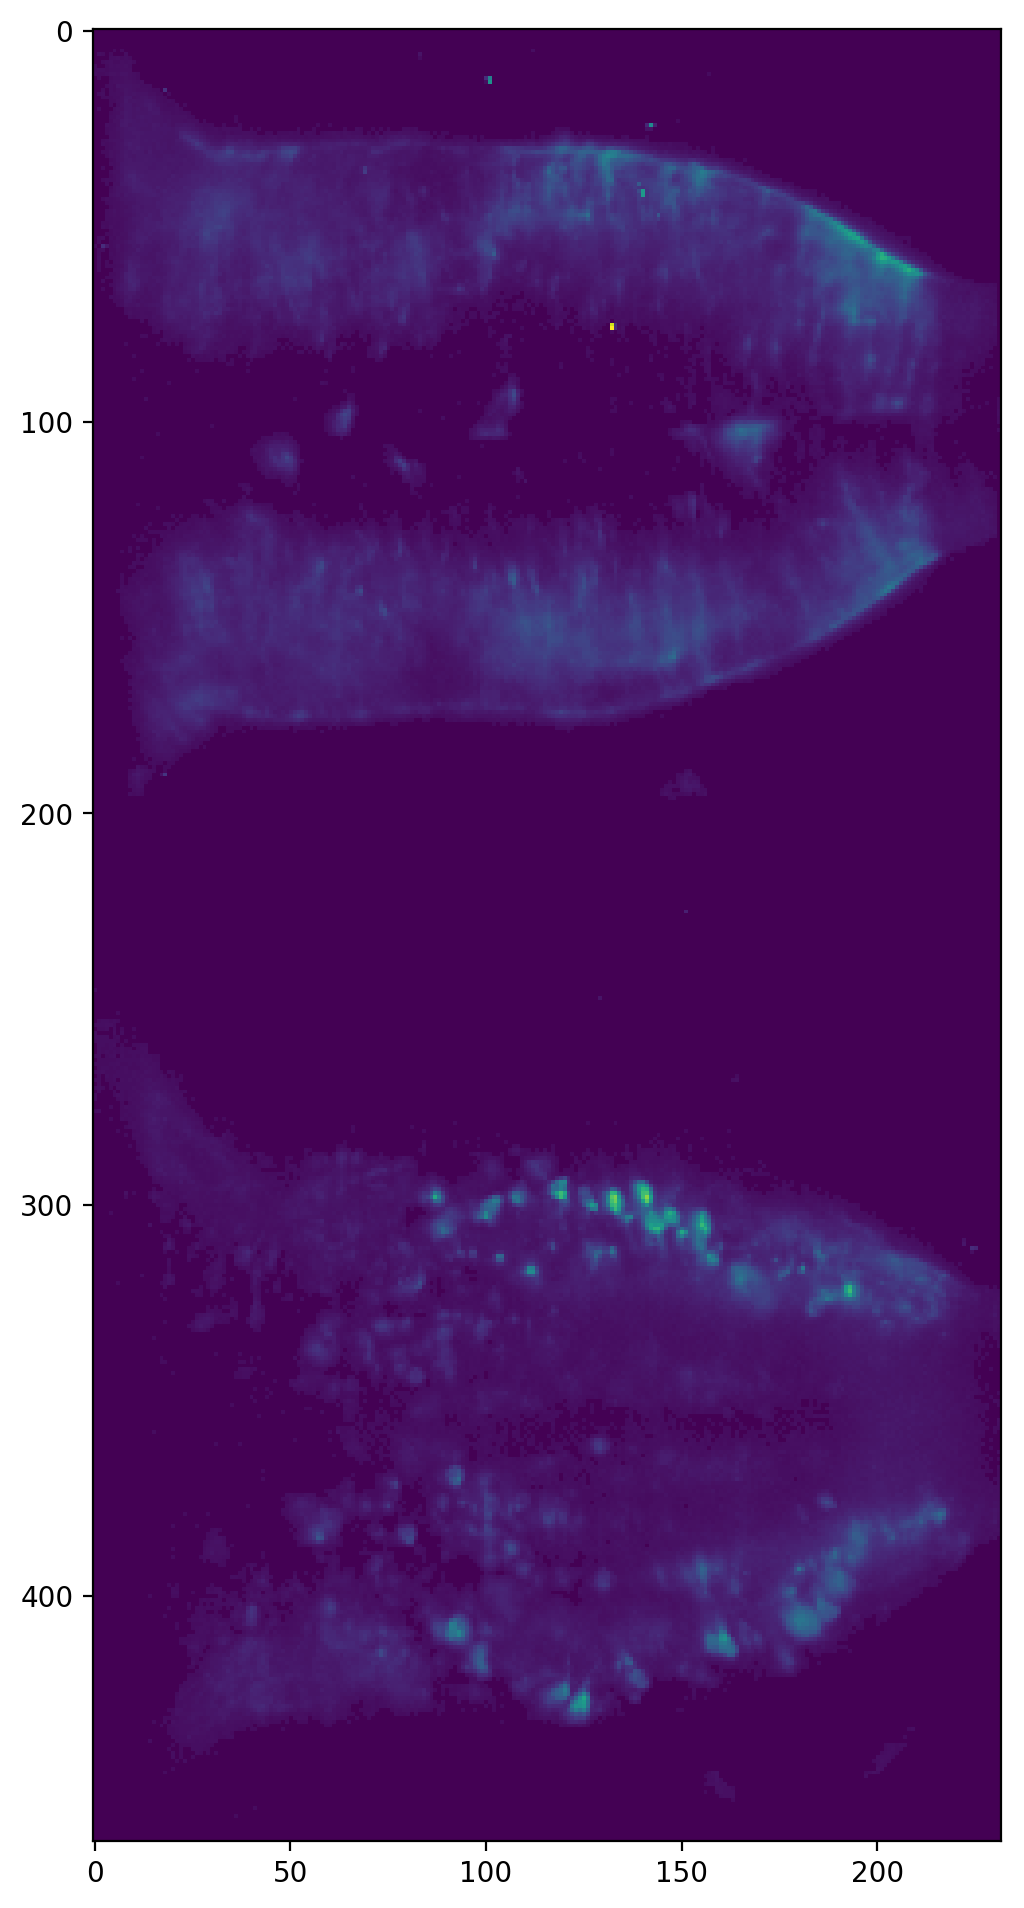

In [4]:
roi = slice(0, 10000), slice(None), slice(None)
fig, axs = plt.subplots(figsize=(12,12), dpi=200)
mx  = data[roi].max(0)
thr = .2
thrm = (mx > thr)
plt.imshow(mx * thrm)

In [8]:
win = flw(data)

In [9]:
roi_ts = np.array([data[roi].T[r.getMask()[::-1]].mean(0) for r in win.rois]).T

In [45]:
zsc = zscore(data[roi], axis=0)

In [48]:
redim(zsc,2).shape

(10000, 107416)

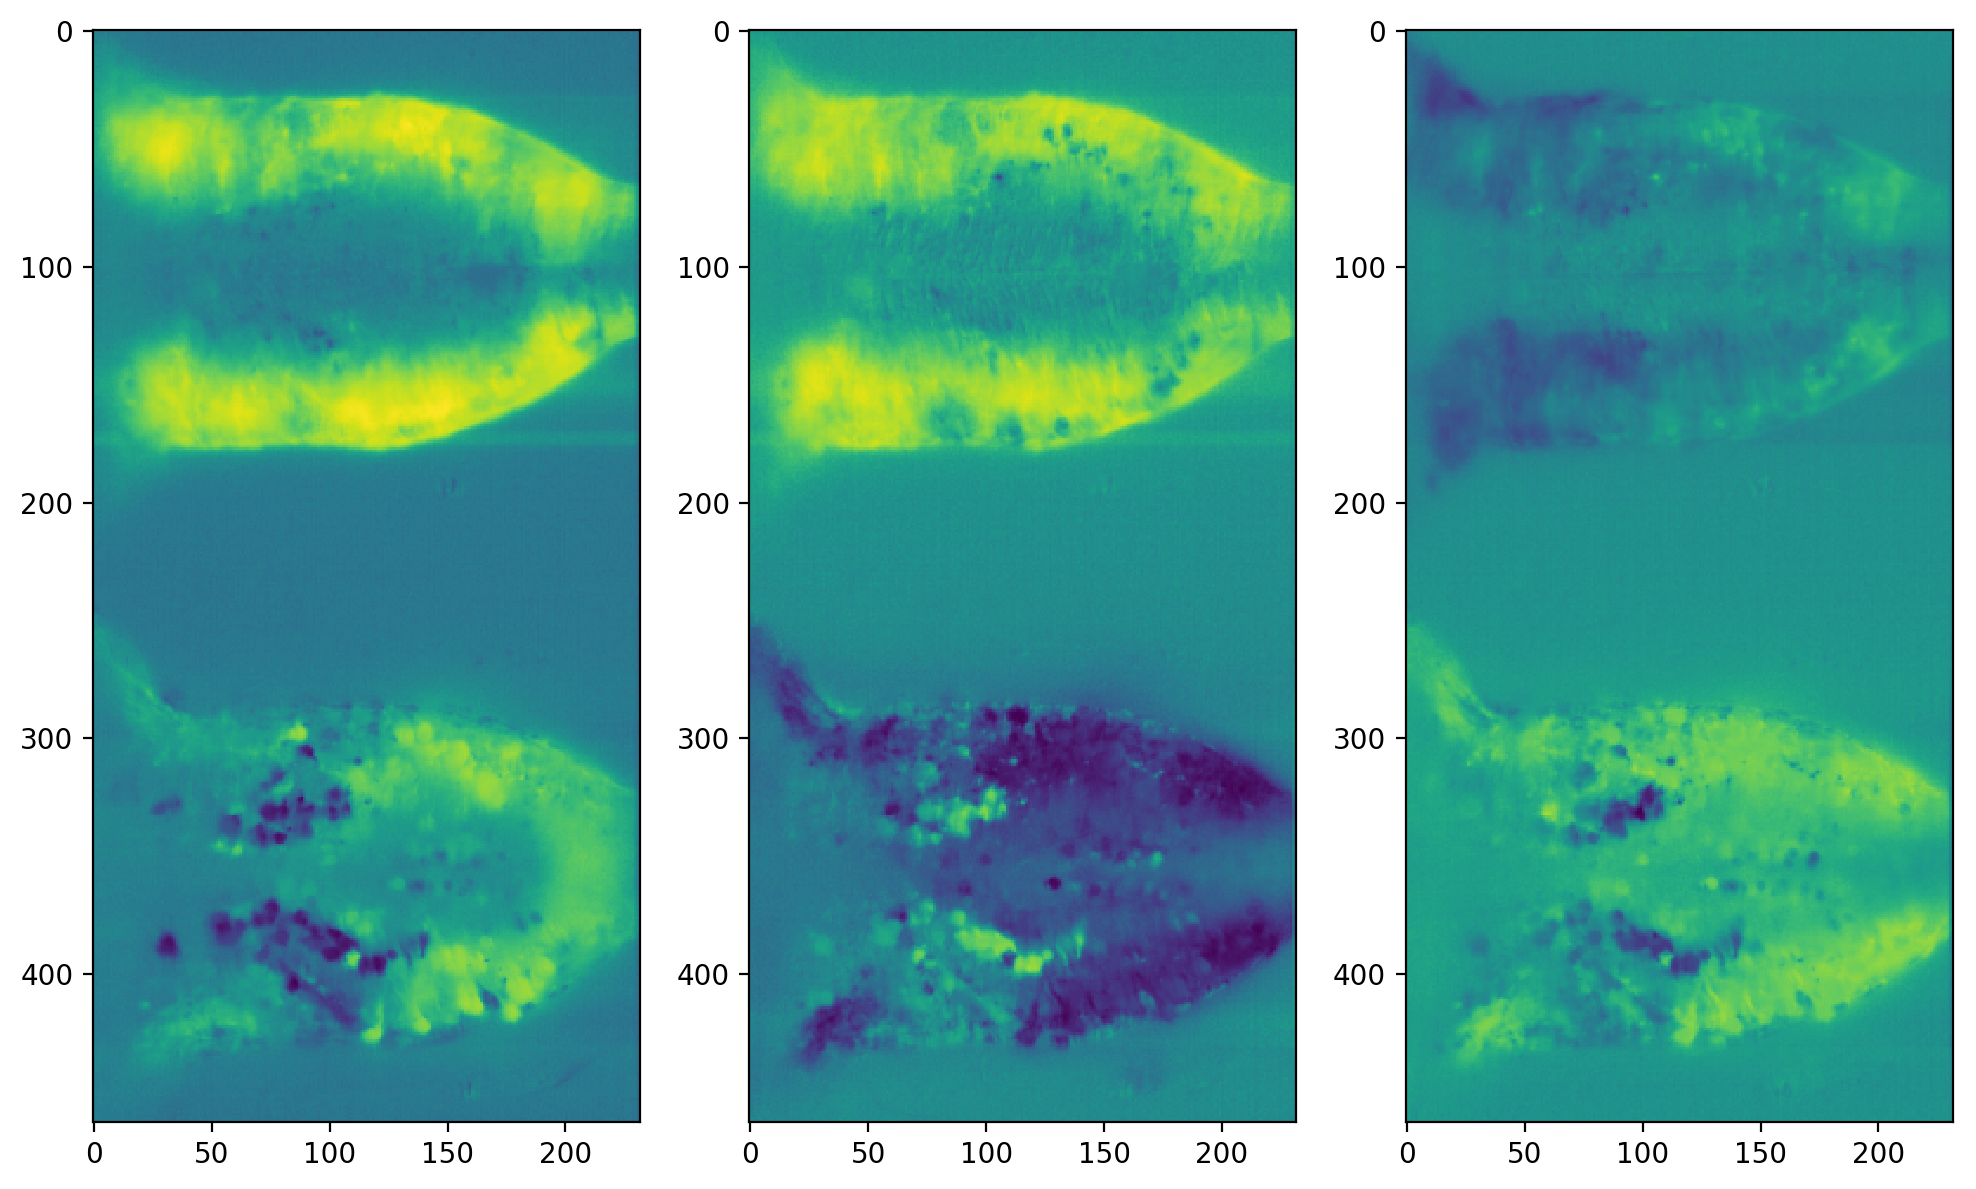

In [72]:
fig, axs = plt.subplots(figsize=(12,12), ncols=3, dpi=200)
ne_map = np.dot(redim(zsc,2).T, zscore(roi_ts[:,0])).reshape(zsc.shape[1:])/ roi_ts.shape[0]
g_map = np.dot(redim(zsc,2).T, zscore(roi_ts[:,1])).reshape(zsc.shape[1:])/ roi_ts.shape[0]
prod_map = np.dot(redim(zsc,2).T, zscore(roi_ts[:,1] * roi_ts[:,0])).reshape(zsc.shape[1:]) / roi_ts.shape[0]
axs[0].imshow(prod_map)
axs[1].imshow(prod_map - ne_map, clim=(-.5,.5))
axs[2].imshow(prod_map - g_map, clim = (-.5,.5))

In [43]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
output_notebook()
x = np.arange(roi_ts.shape[0])
f = figure(width=800, height=300)
f.line(x,zscore(roi_ts[:,2]), color='black')
f.line(x,zscore(roi_ts[:,0] * roi_ts[:,1]), line_width=3)
show(f)

Loading BokehJS ...

In [41]:
data_thr = data_flat.T[thrm.ravel(),:]
data_thr -= data_thr.min()

In [42]:
data_thr.shape

(48022, 36500)

In [98]:
%%time
nmf = NMF(n_components=30, random_state=0).fit(data_thr[:,roi[0]])
w = nmf.transform(data_thr[:,roi[0]])

CPU times: user 36min 32s, sys: 10.6 s, total: 36min 42s
Wall time: 4min 26s


In [99]:
w_full = np.array([unfilter_flat(w_, thrm) for w_ in w.T])

In [104]:
flw(w_full)

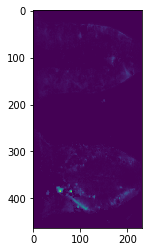

In [220]:
plt.imshow(w_full[11])

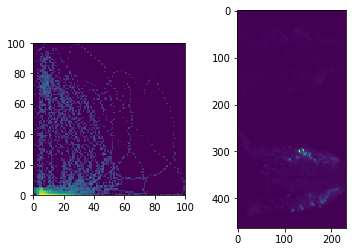

In [276]:
fig, axs = plt.subplots(ncols=2)
cmp = 1
cmp_ts = zscore(nmf.components_[cmp])
cmp_w = w_full[cmp]
hist = np.histogram2d(cmp_ts, zscore(roi_ts).squeeze(), bins=100)[0]
axs[0].pcolor(np.log(1 + hist))
axs[0].axis('square')
axs[1].imshow(cmp_w)

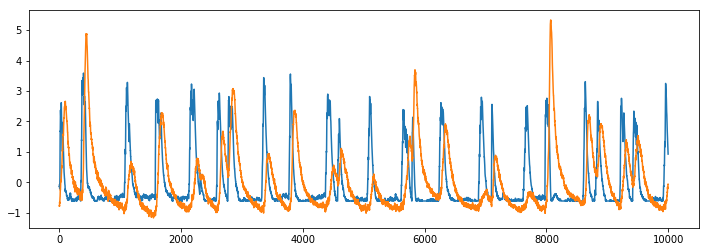

In [157]:
from scipy.stats import zscore
fig, axs = plt.subplots(figsize=(12,4))
plt.plot(zscore(nmf.components_[1]))
#plt.plot(zscore(nmf.components_[9]))
plt.plot(zscore(roi_ts))
#plt.xlim(0,3000)

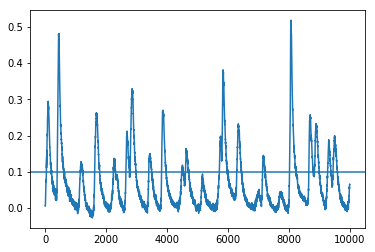

In [281]:
from fish.ephys.ephys import estimate_onset
thr_g  = .1
plt.plot(roi_ts)
plt.axhline(thr_g)

In [393]:
tr = estimate_onset(roi_ts, thr_g, 300)
plr=np.arange(-200,300)
trials = tr.reshape(-1,1) + plr

In [392]:
trials.shape

(12, 500)

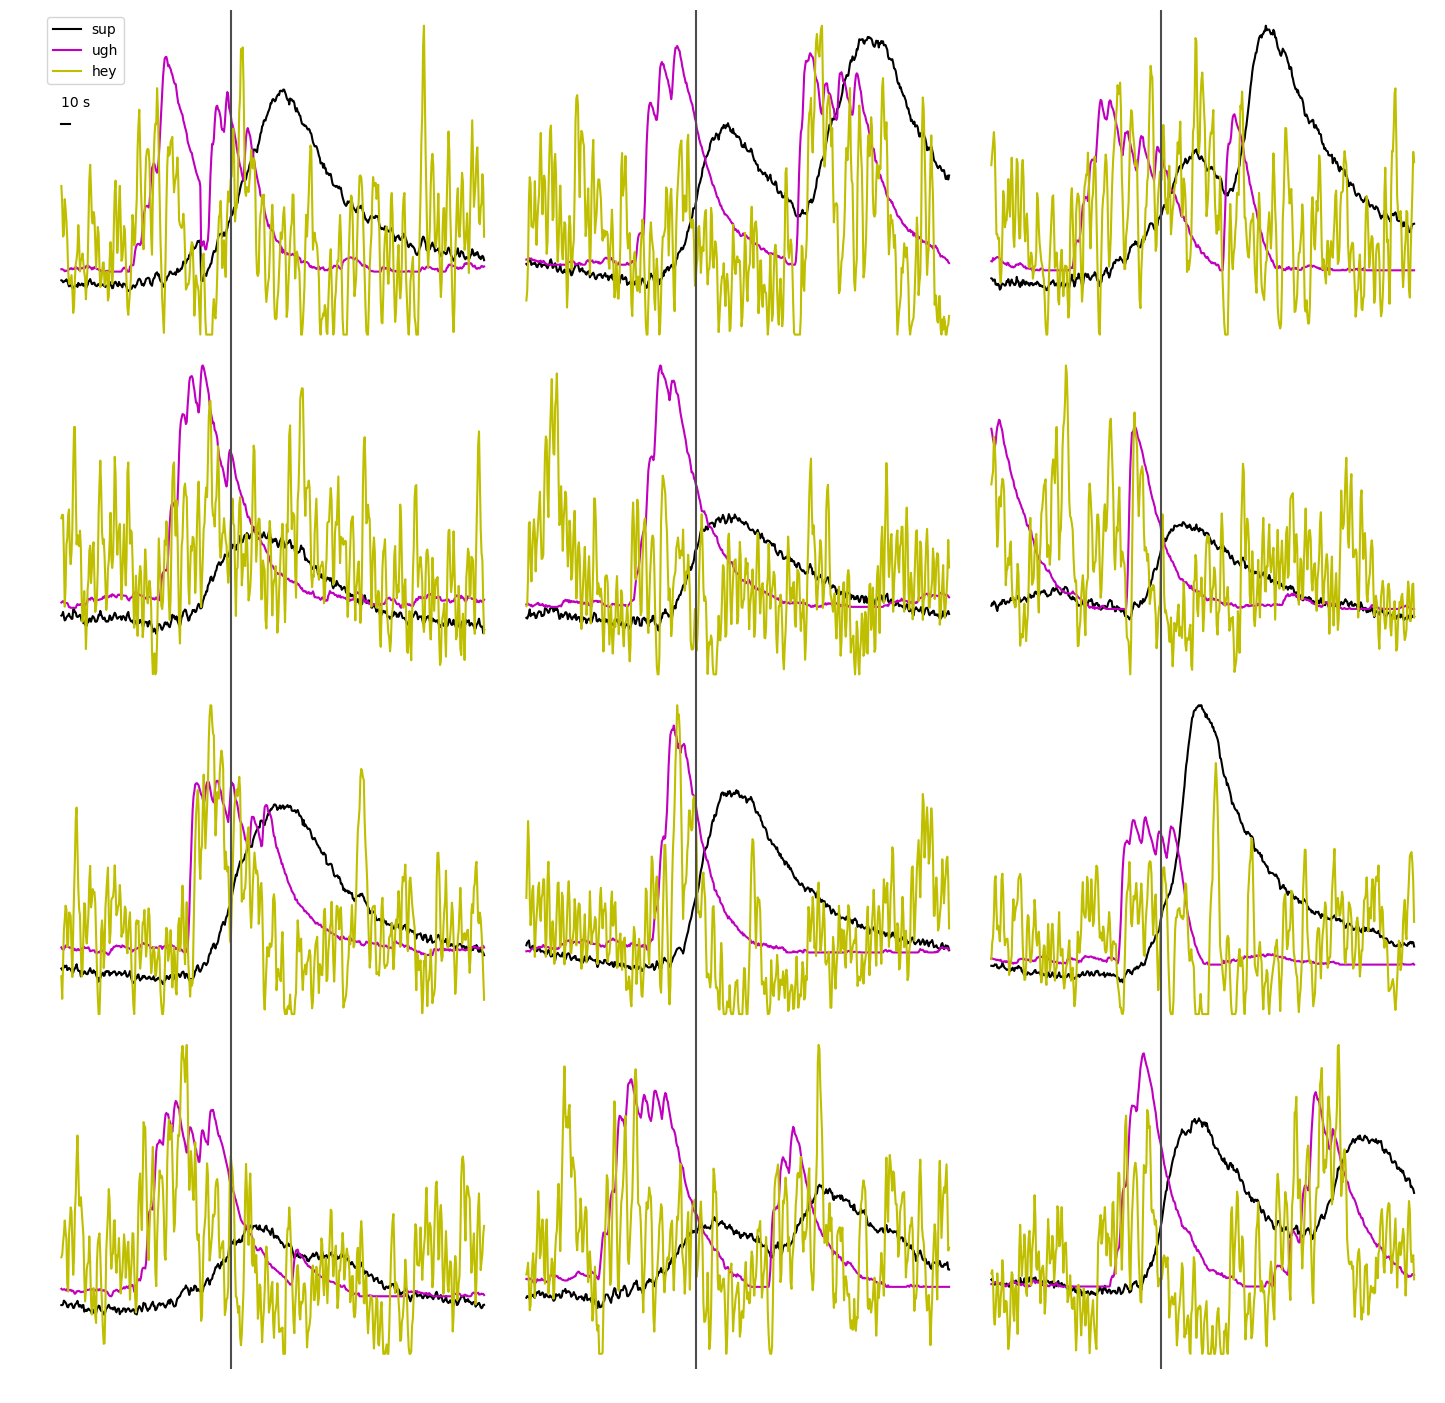

In [436]:
plr_t = plr
ncols = 3
fig, axs = plt.subplots(figsize=(18,18), ncols=ncols, nrows=np.ceil(trials.shape[0] / ncols).astype('int'), dpi=100)
to_plot = (zscore(roi_ts), zscore(nmf.components_[1]), zscore(nmf.components_[9]))
colors=('k','m','y')
labels=('sup','ugh','hey')
[ax.axis('off') for ax in axs.ravel()]
for ind, trial in enumerate(trials):
    curax = axs.T.ravel()[ind]
    [curax.plot(plr_t, val[trial], color=colors[ind], label=labels[ind]) for ind, val in enumerate(to_plot)]
    curax.axvline(0, color=(.3,.3,.3))
    

scale_bar_len = 10
scale_bar_pos = [plr_t[0],plr_t[0] + scale_bar_len], [axs[0][0].get_ylim()[-1]/2] * 2
axs[0][0].plot(*scale_bar_pos, color='k')
axs[0][0].text(scale_bar_pos[0][0], scale_bar_pos[1][0] * 1.15, f'{scale_bar_len} s')
axs[0][0].legend()
#plt.suptitle(f'{exp_name} \n epochs triggered on LH glial activity \n sorted by LH glial activity ')
plt.subplots_adjust(hspace=0,wspace=0)


In [ ]:
ncols = 4
fig, axs = plt.subplots(figsize=(18,18), ncols=ncols, nrows=np.ceil(trials.shape[1] / ncols).astype('int'), dpi=100)

sig1 = zscore(nmf.components_[2])
sig2 = zscore(nmf.components_[3])

fs_im = 30

plr_t = plr * fs_im
colors = ('c','k', 'm', 'g')
to_plot = (zsc[:,0], sig1, sig2, zsc[:,1])
labels = ('LC','NMF: LH 2', 'NMF: LH 37', 'LH glia')

[ax.axis('off') for ax in axs.ravel()]
for ind, trial in enumerate(tr_sorted_g.T):
    curax = axs.T.ravel()[ind]
    [curax.plot(plr_t, val[trial], color=colors[ind], label=labels[ind]) for ind, val in enumerate(to_plot)]
    curax.axvline(0, color=(.3,.3,.3))
    

scale_bar_len = 10
scale_bar_pos = [plr_t[0],plr_t[0] + scale_bar_len], [axs[0][0].get_ylim()[-1]/2] * 2
axs[0][0].plot(*scale_bar_pos, color='k')
axs[0][0].text(scale_bar_pos[0][0], scale_bar_pos[1][0] * 1.15, f'{scale_bar_len} s')
axs[0][0].legend()
plt.suptitle(f'{exp_name} \n epochs triggered on LH glial activity \n sorted by LH glial activity ')
plt.subplots_adjust(hspace=0,wspace=0)